In [1]:
# nts: activate langchain_env 
import cdsapi
import logging
from tqdm import tqdm
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys
import contextlib
import threading
from pyproj import Proj 
from scipy.interpolate import RegularGridInterpolator

trackspath1='/home/sonia/mcms/tracker/1940-2010/era5/out_era5/era5/mcms_era5_1940_2010_tracks.txt'
trackspath2='/home/sonia/mcms/tracker/2010-2024/era5/out_era5/era5/mcms_era5_2010_2024_tracks.txt'
joinyear = 2010 # overlap for the track data
use_slp = False # whether to include slp channel
use_windmag = True #include wind magnitude channel
use_winduv = False # (Not implemented) include wind u and v components channels
threads = 1
outpath = '/home/cyclone/train/windmag_natlantic'

In [2]:
regmask = xr.open_dataset('/home/cyclone/regmask_0723_anl.nc')
# atlantic ocean is regmask['reg_name'].values[109] # so 110 in regmaskoc values
reg_id = 110

In [3]:
# make dataframe of all tracks 
tracks1 = pd.read_csv(trackspath1, sep=' ', header=None, 
        names=['year', 'month', 'day', 'hour', 'total_hrs', 'unk1', 'unk2', 'unk3', 'unk4', 'unk5', 'unk6', 
               'z1', 'z2', 'unk7', 'tid', 'sid'])
# storms that start before the join year (even if they continue into the join year):
sids1 = tracks1[(tracks1['sid']==tracks1['tid']) & (tracks1['year']<joinyear)]['sid'].unique()
tracks1 = tracks1[tracks1['sid'].isin(sids1)]

tracks2 = pd.read_csv(trackspath2, sep=' ', header=None, 
        names=['year', 'month', 'day', 'hour', 'total_hrs', 'unk1', 'unk2', 'unk3', 'unk4', 'unk5', 'unk6', 
               'z1', 'z2', 'unk7', 'tid', 'sid'])
# filter out storms that "start" at the beginning of the join year since they probably started before and are 
# included in tracks1
sids2 = tracks2[(tracks2['sid']==tracks2['tid']) & \
        ((tracks2['year']>=joinyear) | (tracks2['month']>1) | (tracks2['day']>1) | (tracks2['hour']>0))]['sid'].unique()
tracks2 = tracks2[tracks2['sid'].isin(sids2)]

tracks = pd.concat([tracks1, tracks2], ignore_index=True)
tracks = tracks.sort_values(by=['year', 'month', 'day', 'hour'])

# conversions from the MCMS lat/lon system, as described in Jimmy's email:
tracks['lat'] = 90-tracks['unk1'].values/100
tracks['lon'] = tracks['unk2'].values/100

tracks = tracks[['year', 'month', 'day', 'hour', 'tid', 'sid', 'lat', 'lon']]
tracks

,year,month,day,hour,tid,sid,lat,lon
0,1940,1,1,0,19400101000070033200,19400101000070033200,82.80,332.13
1,1940,1,1,0,19400101000110009450,19400101000110009450,78.88,94.31
2,1940,1,1,0,19400101000110034050,19400101000110034050,79.02,340.65
3,1940,1,1,0,19400101000140006200,19400101000140006200,76.19,61.77
4,1940,1,1,0,19400101000140017350,19400101000140017350,76.13,173.53
...,...,...,...,...,...,...,...,...
3982141,2024,3,1,23,20240301231315020250,20240301221305020100,-41.35,202.70
3982142,2024,3,1,23,20240301231560005400,20240301221565005400,-65.98,54.05
3982143,2024,3,1,23,20240301231740003750,20240301221735003450,-83.91,37.52
3982144,2024,3,1,23,20240301231760035300,20240301221775002650,-86.01,352.99


In [4]:
# sanity check, count the number of storms in the N Atlantic
sids = tracks[tracks['tid'] == tracks['sid']]
natlantic = 0
for _, sid in sids.iterrows():
    if sid['lat'] > 0 and 110 in regmask.sel(lono=sid['lon'], lato=sid['lat'], method='nearest')['regmaskoc'].values:
        natlantic += 1
natlantic

4668

In [5]:
varnames = [] # list of variables that will be included in this output dataset
varlocs = {'slp': '/home/cyclone/slp/', 'wind': '/home/cyclone/wind'} # where the source data is stored 
varfuncs = {}
if use_slp:
    varnames.append('slp')
    def f_slp(ds, lats, lons): # function to run when new SLP file is loaded
        return ds.sel(lat=lats, lon=lons, time=time)['slp']
    varfuncs['slp'] = f_slp
if use_windmag:
    varnames.append('wind')
    def f_wind(ds, lats, lons, time):
        u = ds.sel(lat=lats, lon=lons, time=time)['u10']
        v = ds.sel(lat=lats, lon=lons, time=time)['v10']
        windmag = np.sqrt(u**2 + v**2)
        return windmag
    varfuncs['wind'] = f_wind
varnames, varfuncs

(['wind'], {'wind': <function __main__.f_wind(ds, lats, lons, time)>})

In [7]:
resolution = 0.5 # resolution of data in degs
l = 800 # (half length: l/2 km from center in each direction)
s = 32 # box will be dimensions s by s (eg 32x32)
x_lin = np.linspace(-l, l, s)
y_lin = np.linspace(-l, l, s)
x_grid, y_grid = np.meshgrid(x_lin, y_lin) # equal-spaced points from -l to l in both x and y dimensions

cur_year = 1940 
end_year = 2024
cur_datas = {}
next_datas = {}
for var in varnames:
    cur_data = xr.open_dataset(f'{varlocs[var]}/{var}.{cur_year}.nc', engine='netcdf4')
    correct_time = cur_data['time'].values[0] + pd.to_timedelta(np.arange(cur_data.dims['time']) * 6, unit='h')
    cur_data = cur_data.assign_coords(time=correct_time) # incase it wasn't read in as 6hrly
    cur_datas[var] = cur_data
    next_data = xr.open_dataset(f'{varlocs[var]}/{var}.{cur_year+1}.nc', engine='netcdf4')
    correct_time = next_data['time'].values[0] + pd.to_timedelta(np.arange(next_data.dims['time']) * 6, unit='h')
    next_data = next_data.assign_coords(time=correct_time) # incase it wasn't read in as 6hrly
    next_datas[var] = next_data

def prep_point(df, thread=0):
    """make one training datapoint. df contains year/../hr, lat, lon of center"""
    boxes = []
    file_year = cur_year
    for _, frame in df.iterrows():
        year, month, day, hour = frame['year'], frame['month'], frame['day'], frame['hour']
        time = f'{year}-{month:02d}-{day:02d}T{hour:02d}:00:00'
        if year != file_year: # go to next file year 
            file_year += 1
            for var in varnames:
                cur_datas[var] = next_datas[var]
                if file_year < end_year:
                    next_data = xr.open_dataset(f'{varlocs[var]}/{var}.{file_year+1}.nc', engine='netcdf4')
                    correct_time = next_data['time'].values[0] + pd.to_timedelta(np.arange(next_data.dims['time']) * 6, unit='h')
                    next_data = next_data.assign_coords(time=correct_time) # incase it wasn't read in as 6hrly
                    next_datas[var] = next_data
                else:
                    next_datas[var] = None
        
        lat_center, lon_center = frame['lat'], frame['lon']
        # 'aeqd': https://proj.org/en/stable/operations/projections/aeqd.html
        proj_km = Proj(proj='aeqd', lat_0=lat_center, lon_0=lon_center, units='km')
        # Project to find lat/lon corners of the equal-area box
        lon_grid, lat_grid = proj_km(x_grid, y_grid, inverse=True) #translate km to deg
        lon_grid=(lon_grid+360)%360 # because these datasets have lon as 0 to 360 (lat is still -90 to 90)
        lon_min = lon_grid.min() - resolution # +- reso because otherwise xarray will not include the edge points
        lon_max = lon_grid.max() + resolution
        lat_min = lat_grid.min() - resolution
        lat_max = lat_grid.max() + resolution
        # print(lat_max, lat_min, lon_min, lon_max)
        
        slices = []
        for var in varnames:
            data = varfuncs[var](cur_datas[var], slice(lat_max, lat_min), slice(lon_min, lon_max), time)
            slices.append(data.sortby(['lat', 'lon']).squeeze().values)
        rawbox = np.stack(slices).squeeze() # squeeze -- only works with 1 channel for now
        # print(rawbox)
        
        # Build interpolator
        interp = RegularGridInterpolator(
            (data.lat.values, data.lon.values),
            rawbox,
            bounds_error=False,
            fill_value=np.nan
        )

        # Interpolate at new (lat, lon) pairs
        interp_points = np.stack([lat_grid.ravel(), lon_grid.ravel()], axis=-1)
        interp_values = interp(interp_points).reshape(s, s)
        boxes.append(interp_values)
        
    datapoint = np.stack(boxes, axis=0)
    return datapoint

/tmp/ipykernel_9589/458489670.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  correct_time = cur_data['time'].values[0] + pd.to_timedelta(np.arange(cur_data.dims['time']) * 6, unit='h')
/tmp/ipykernel_9589/458489670.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  correct_time = next_data['time'].values[0] + pd.to_timedelta(np.arange(next_data.dims['time']) * 6, unit='h')


In [8]:
# list(tracks[(tracks['year']==1940) & (tracks['lat']< 70) & (tracks['lat']>-70) & (tracks['lon']<300) & (tracks['lon']>30)]['tid'].unique())

In [9]:
box = prep_point(tracks[tracks['sid']=='19400101000225011150'])
box.shape

(4, 32, 32)

In [10]:
sids = tracks['sid'].unique()
RADIUS=6371 # Earth radius in km

if not os.path.exists(outpath):
    os.makedirs(outpath)
readme = """small debugging dataset: 32x32 of just slp, 8 frames long, over [1940,1942]"""
with open(f'{outpath}/README.txt', 'w') as f:
    f.write(readme)

def worker(sids_chunk, thread_id):
    for i, sid in enumerate(sids_chunk):
        if i % 100 == 0:
            print(f'Thread {thread_id}: Processing sid {i}/{len(sids_chunk)}: {i/len(sids_chunk)*100:.2f}% complete')
        sid_df = tracks[tracks['sid'] == sid]
        start_lat = sid_df['lat'].iloc[0]
        start_lon = sid_df['lon'].iloc[0]
        if len(sid_df) < 8: # storm too short
            continue
        elif sid_df[sid_df['tid']==sid]['lat'].abs().iloc[0] > 70:
            continue # starts poleward of 70 degrees
        elif start_lat < 0 or 110 not in regmask.sel(lono=start_lon, lato=start_lat, method='nearest')['regmaskoc'].values:
            continue # only get north atlantic ocean area
        
        sid_df = sid_df.sort_values(by=['tid'])
        sid_df = sid_df.iloc[:8]  # only take the first 8 frames for debugging
        
        point = prep_point(sid_df)
        os.makedirs(f'{outpath}/{sid}', exist_ok=True)
        for i, frame in enumerate(point):
            np.save(f'{outpath}/{sid}/{i}.npy', frame)

In [ ]:
for i in range(threads):
    start = i * len(sids) // threads
    end = (i + 1) * len(sids) // threads
    sids_chunk = sids[start:end]
    print(start, end, sids_chunk.shape)
    thread = threading.Thread(target=worker, args=(sids_chunk, i))
    thread.start()
    # worker(sids_chunk, i)
    
for i in range(threads):
    thread.join()
print("All threads completed.")

0 361154 (361154,)
Thread 0: Processing sid 0/361154: 0.00% complete
Thread 0: Processing sid 100/361154: 0.03% complete
Thread 0: Processing sid 200/361154: 0.06% complete
Thread 0: Processing sid 300/361154: 0.08% complete
Thread 0: Processing sid 400/361154: 0.11% complete
Thread 0: Processing sid 500/361154: 0.14% complete
Thread 0: Processing sid 600/361154: 0.17% complete
Thread 0: Processing sid 700/361154: 0.19% complete
Thread 0: Processing sid 800/361154: 0.22% complete
Thread 0: Processing sid 900/361154: 0.25% complete
Thread 0: Processing sid 1000/361154: 0.28% complete
Thread 0: Processing sid 1100/361154: 0.30% complete
Thread 0: Processing sid 1200/361154: 0.33% complete
Thread 0: Processing sid 1300/361154: 0.36% complete
Thread 0: Processing sid 1400/361154: 0.39% complete


In [ ]:
from pyproj import Proj, Transformer
import numpy as np 
import xarray as xr 

In [ ]:
from shapely import Polygon, Point

In [76]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 1464, lat: 361, lon: 720)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 3kB 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * time     (time) datetime64[ns] 12kB 1940-01-01 ... 1940-12-31T18:00:00
Data variables:
    slp      (time, lat, lon) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T19:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [109]:
slice(lat_max, lat_min), slice(lon_min, lon_max)

(slice(np.float64(39.53395424954598), np.float64(20.15105106672381), None),
 slice(np.float64(-171.30287331021157), np.float64(-147.39712668978837), None))

In [114]:
lon_grid

array([[-168.91174691, -168.29676457, -167.6814046 , ..., -151.0185954 ,
        -150.40323543, -149.78825309],
       [-168.95392355, -168.33628686, -167.71825934, ..., -150.98174066,
        -150.36371314, -149.74607645],
       [-168.99708707, -168.37673458, -167.75597762, ..., -150.94402238,
        -150.32326542, -149.70291293],
       ...,
       [-170.63460694, -169.91183858, -169.1880296 , ..., -149.5119704 ,
        -148.78816142, -148.06539306],
       [-170.71770018, -169.98977168, -169.26076321, ..., -149.43923679,
        -148.71022832, -147.98229982],
       [-170.80287331, -170.06965959, -169.33532479, ..., -149.36467521,
        -148.63034041, -147.89712669]], shape=(32, 32))

In [143]:
import numpy as np 
from pyproj import Proj 
import xarray as xr
from scipy.interpolate import RegularGridInterpolator

# load some example data to play with, define practice focus area
ds = xr.open_dataset('/home/cyclone/slp/slp.1940.nc')
resolution = 0.5
lat_center = -30.02
lon_center = 100.65

# Define projected x/y bounds in km (e.g., ±100 km, ±100 km around center)
l = 1000 # half-length of a side of the box in km
s = 32 # box will be dimensions s by s (eg 32x32)
x_lin = np.linspace(-l, l, s)
y_lin = np.linspace(-l, l, s)
x_grid, y_grid = np.meshgrid(x_lin, y_lin) # equal-spaced points from -l to l in both x and y dimensions

# Azimuthal equidistant ('aeqd'): https://proj.org/en/stable/operations/projections/aeqd.html
proj_km = Proj(proj='aeqd', lat_0=lat_center, lon_0=lon_center, units='km') #lat center, lon center are (0,0) in the projected space
lon_grid, lat_grid = proj_km(x_grid, y_grid, inverse=True) #translate km to deg
lon_grid=(lon_grid+360)%360

lon_min = lon_grid.min() - resolution # +- reso because otherwise xarray will not include the edge points
lon_max = lon_grid.max() + resolution
lat_min = lat_grid.min() - resolution
lat_max = lat_grid.max() + resolution
print(lon_grid[0,0], lon_grid[0,-1], lon_grid[-1,0], lon_grid[-1, -1])
print(lon_min, lon_max)
print(lat_grid[0,0], lat_grid[0,-1], lat_grid[-1,0], lat_grid[-1, -1])
print(lat_min, lat_max)

subset = ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max), time='1940-12-31T18:00:00')['slp']
subset = subset.sortby(['lat', 'lon'])  # ensure lat/lon are sorted for interpolation

# Build interpolator
interp = RegularGridInterpolator(
    (subset.lat.values, subset.lon.values),
    subset.values,
    bounds_error=False,
    fill_value=np.nan
)

# Interpolate at new (lat, lon) pairs
interp_points = np.stack([lat_grid.ravel(), lon_grid.ravel()], axis=-1)
interp_values = interp(interp_points).reshape(32, 32)
subset.values.shape

89.19712668978843 112.10287331021158 91.08825309322742 110.21174690677265
88.69712668978843 112.60287331021158
-38.54364050445711 -38.54364050445711 -20.65105106672381 -20.65105106672381
-39.53395424954598 -20.15105106672381


(39, 48)

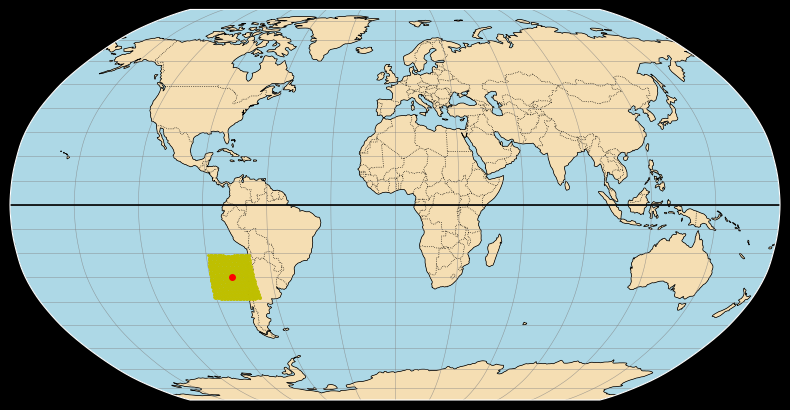

In [144]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

lat = lat_center
lon = lon_center - 180

fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-90, central_latitude=20))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor='lightblue')
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='wheat')
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('110m'), linestyle=':', linewidth=0.5)

# Gridlines (meridians and parallels)
meridians = np.arange(-180, 180, 30)
parallels = np.arange(-80, 90, 10)

# Draw meridians
for mer in meridians:
    ax.plot([mer]*181, np.linspace(-90, 90, 181),
            transform=ccrs.PlateCarree(), color='gray', linewidth=0.4, alpha=0.7)

# Draw parallels
for par in parallels:
    ax.plot(np.linspace(-180, 180, 361), [par]*361,
            transform=ccrs.PlateCarree(), color='gray', linewidth=0.4, alpha=0.7)

# Highlight equator in red
ax.plot(np.linspace(-180, 180, 361), [0]*361,
        transform=ccrs.PlateCarree(), color='black', linewidth=1.2)

# equal-area box coords
for i in range(interp_points.shape[0]):
        ax.plot(interp_points[i,1]-180, interp_points[i,0], 'yo', markersize=1, transform=ccrs.PlateCarree())

# Add red dot (center spot)
ax.plot(lon, lat, 'ro', markersize=4, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [162]:
lat_grid[-1,0], lon_grid[-1,0]-180, lat_grid[-1,-1], lon_grid[-1,-1]-180

(61.40380704005244, -54.420973092741335, 61.40380704005244, -24.27902690725864)

In [163]:
lat, lon

(55.02, -39.349999999999994)

In [ ]:
# # check total distance traveled (sum of great circle)
        # lat1 = np.radians(sid_df['lat'].to_numpy()[:-1])
        # lon1 = np.radians(sid_df['lon'].to_numpy()[1])
        # lat2 = np.radians(sid_df['lat'].to_numpy()[1:])
        # lon2 = np.radians(sid_df['lon'].to_numpy()[1:])
        # dlat = lat2 - lat1
        # dlon = lon2 - lon1
        # a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        # c = 2 * np.arcsin(np.sqrt(a))
        # dist = np.sum(RADIUS * c)